# 7장 시계열 데이터를 다뤄보자
데이터를 다룬다는 말 속에는 다양한 분야와 응용을 담고 있습니다. 그런데 데이터가 시간의 흐름에 따라 변화하는 추이가 있는 데이터, 대표적으로 웹 트래픽이나 주식 같은 데이터를 예측할 해야 할 때가 있습니다.<br>
시계열(Time Series)분석이라는 것은 통계적으로 어렵고 복잡한 작업입니다. 원 데이터의 안정성(stationary)을 판정하고, 안정한 형태로 변환하고, 예측 모델을 선정하고 검증하는 과정이 통계학의 깊은 지식을 요구합니다.<br>
그러나 통계 전문가에게 맡기기 전에 간단히 데이터 예측하는 가벼운 느낌이라면 이 책에서는 유용한 도구를 하나 소개할까 합니다. 페이스북에서 만든 fbprophet이라는 모듈입니다. Fbprophet을 사용하기 위해서는 몇 가지 절차를 거쳐야 합니다. 먼저 윈도우 유저들은 Visual C++ Build Tools를 설치해야 합니다. 맥유저는 이 절차가 필요 없습니다. 그리고 터미널에서 pip install pystan과 pip install prothet을 수행합니다. 이제 시계열 예측을 수행해 보도록 하겠습니다.

## 7-1 Numpy의 polyfit으로 회귀(regression) 분석하기

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet
from datetime import datetime

Importing plotly failed. Interactive plots will not work.


이번 장에서 사용할 모듈을 미리 import합니다. 특히 import pandas_datareader.data as wed에서 사용하는 pandas_datareader는 터미널에서 pip install pandas_datareader로 설치해야 합니다.

In [2]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    print('Mac version')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    print('Windows version')
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumFont/NanumGothicBold.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
    print('Linux version')
else:
    print('Unknown system... sorry~~~~')

Linux version


매 장마다 등장하는 matplotlib에서 한글 폰트 문제에 대한 코드도 실행합니다.

In [13]:
pinkwink_wed = pd.read_csv('data/08. PinkWink Web Traffic.csv',
                          encoding='utf-8', thousands=',',
                          names = ['date','hit'], index_col=0)
pinkwink_wed = pinkwink_wed[pinkwink_wed['hit'].notnull()]
pinkwink_wed.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


https://goo.gl/5wWzLL에서 08. PinkWink Web Traffic.csv라는 데이터를 받아서 data 폴더에 저장합니다.<br>
책 전반에 걸쳐 나타나짐만 저는 블로그 하나를 아주 오래 전부터 운용하고 있습니다. 처음에는 당시 시간 강의하던 수업 자료를 올릴 곳이 없어서 시작한 것이었는데 벌써 10년이 넘었습니다. 비록 공학도의 블로그이고 워낙 기초나 튜토리얼과 같은 쉬운 주제만 다루는 데다, 이것저것 잡다하게 다루다보니 딱히 인기는 없지만 나름대로 제가 세상과 소통하는 하나의 도구였습니다. 이번 실습 재료는 제 블로그의 웹 트래픽을 대상으로 하고 있습니다. 이 책이 도움이 되었다면 제 블로그에 오셔서 인사말 한 마니 부탁드립니다.

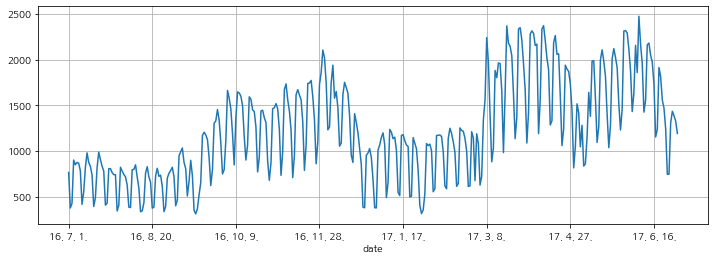

In [14]:
pinkwink_wed['hit'].plot(figsize=(12,4), grid=True);

단순하게 2016년 7월1일부터 2017년 6월16일까지 유입량을 그려봅니다. 어떤 주기성이 있을 것 같은데 시간 순으로 되어 있는 데이터를 그냥 봐서는 정확하게 잘 모르겠습니다. 물론 유심히 관찰하면 2016년 11월28일부터 2017년4월27일 정도로 약 6개월의 주기성 정도는 육안으로 확인되기도 합니다. 그래도 좀 더 정확한 주기성이 있다면 확인하고 싶습니다.

In [16]:
time = np.arange(0,len(pinkwink_wed))
traffic = pinkwink_wed['hit'].values

fx = np.linspace(0, time[-1], 1000)

먼저 시간축(time)을 만들고 웹 트래픽의 자료를 traffic 변수에 저장합니다. 지금 우리는 코드[4]의 결과로 보이는 그래프를 설명할 간단한 함수를 찾으려고 합니다. 그게 직선일 수도 있고 혹은 다항식으로 표현되는 곳선일 수도 있습니다. 어쨌든 현재 데이터를 간단함 도델로 표현하고 싶다는 뜻입니다. 그런 작업을 보통 회귀(regression)라고 합니다. 그래서 모델읠 1차,2차,3차, 15차 다항식으로 표현하고 그 결과를 확인하려고 합니다.

In [17]:
def error(f,x,y):
    return np.sqrt(np.mean((f(x)-y)**2))

어떤 데이터를 어떤 모델로 표현하려고 하면 그 모델의 적합성을 확인하는 과정이 필요합니다. 그러기 위해서는 참 값과 비교해서 에러(error)를 계산해야 합니다. 그래서 코드[6]에서처럼 에러 함수를 정의했습니다.

In [20]:
fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1)

f2p = np.polyfit(time, traffic, 2)
f2 = np.poly1d(f2p)

f3p = np.polyfit(time, traffic, 3)
f3 = np.poly1d(f3p)

f15p = np.polyfit(time, traffic, 15)
f15 = np.poly1d(f15p)

print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

430.85973081109626
430.6284101894695
429.53280466762925
330.4777304274343


이제 책 초반 CCTV분석에서 사용했던 polyfit과 polyfit를 사용해서 함수로 표현할 수 있습니다. 그렇게 해서 1차,2차,3차,15차 함수로 표현해서 확인했더니 1,2,3차는 에러가 비슷합니다. 우선 그 결과를 그래프로 한번 확인해 보겠습니다.

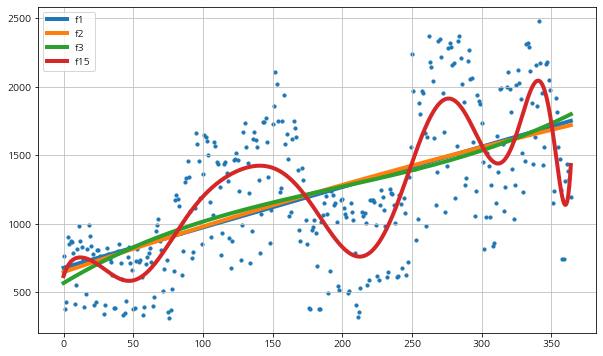

In [21]:
plt.figure(figsize=(10,6))
plt.scatter(time, traffic, s=10)

plt.plot(fx, f1(fx), lw=4, label='f1')
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle='-', color='0.75')
plt.legend(loc=2)
plt.show()

위 결과에서 데이터를 1,2,3,15차 함수로 표현한 결과를 봅시다. 1차,2차,3차가 정의된 함수에서 에러를 확인해 보니 왜 큰 차이가 없는지 알겠습니다. 결국 2차나 3차로 표현하려면 그냥 1차로 표현하는 것이 차라리 나아 보입니다. 그렇다고 15차 함수를 사용해서 표현하는 것은 과적합(over-fitting)일 수 있습니다. 어떤 모델을 선택할지는 결국 분석하는 사람의 몫입니다. 그러나 위 그림만 가지고는 어떤 결론을 내려야 할지 잘 모르겠습니다. 우리는 그 뒷부분, 즉 앞으로의 데이터도 예측하고 싶으니까요.

## 7-2 Prophet 모듈을 이용한 forecast예측
Prophet 모듈은 사용법이 아주 간단합니다. 코드[3]에서 받은 pinkwink_wed 변수에서 날짜(index)와 방문수(hit)만 따로 저장합니다.

In [25]:
df = pd.DataFrame({'ds':pinkwink_wed.index, 'y':pinkwink_wed['hit']})
df.reset_index(inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format="%y. %m. %d.")
del df['date']

m = Prophet(yearly_seasonality=True)
m.fit(df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.2116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       807.526   0.000125179       99.2514      0.2563           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       807.845    1.8543e-07       102.911      0.3463      0.8874      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       807.845   2.29521e-08       93.7549      0.3146           1      272   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [26]:
future = m.make_future_dataframe(periods=60)
future.tail()

,ds
420,2017-08-25
421,2017-08-26
422,2017-08-27
423,2017-08-28
424,2017-08-29


이제 이후 60일간의 데이터를 예측하고 싶다고 make_future_dataframe 명령하면 됩니다.

In [27]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,930.957681,706.524868,1151.265723
421,2017-08-26,515.939255,294.554021,720.989938
422,2017-08-27,648.397740,425.061615,852.566496
423,2017-08-28,1200.952869,971.502582,1421.411510
424,2017-08-29,1236.741771,1016.614995,1442.158506


그리고 예측한 데이터를 forecast 변수에 저장해둡니다.

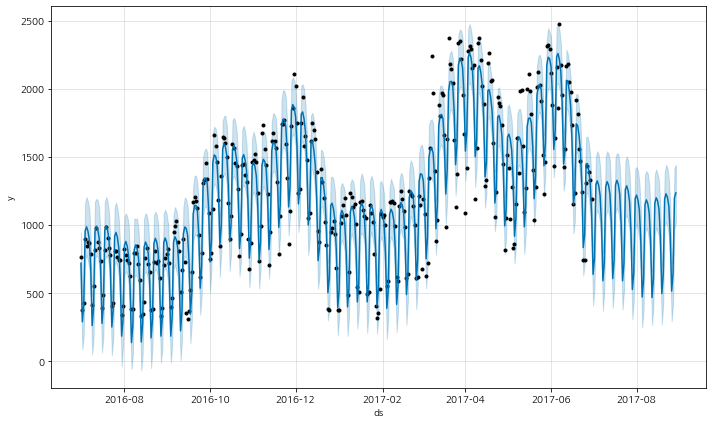

In [28]:
m.plot(forecast);

우리가 받은 2017년 6월 말까지의 데이터 이후 약 2개월(60일)의 예측 결과가 코드[12]의 결과에 나타나 있습니다. 단순히 다항식으로 경향을 파악하는 것보다는 뭔가 나아 보입니다.

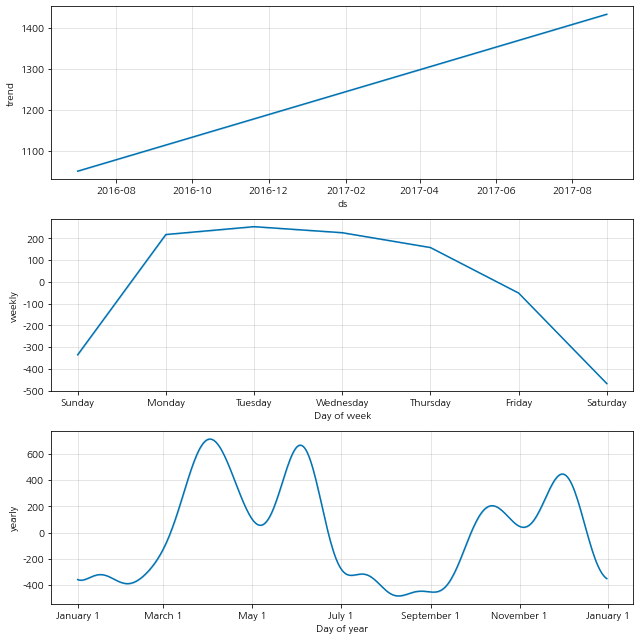

In [29]:
m.plot_components(forecast);

그리고 plot_components 명령으로 몇몇 재미난 결과를 얻을 수 있습니다.<br>
전체적인 경향은 직선으로 표현됩니다.<br>
그리고 제 블로그는 월,화,수요일 방문자가 많다는 것을 알 수 있습니다. 토요일과 일요일은 아주 낮습니다.

그리고 마지막으로 재미있는 것이 제 블로그는 3월부터 상승해서 7월쯤 내려가기 시작합니다. 그 중간 5월에 한 번 숨고르기를 하고 다시 9월경 상승해서 12월경 내려옵니다. 이는 대학교 개강 후 중간고사, 기말고사, 방학과 주기가 비슷합니다. 아무래도 공대에서 좋아하는 포스팅이 많아서인가 봅니다 <br>
Prophet을  사용해서 간략하게 제 블로그를 대상으로 흥미로운 결과를 얻었습니다. 앞으로의 예측부터 주별,연간 데이터의 현황도 알 수 있게 되었습니다. 비록 빈약하긴 하지만 이러한 과정을 Seasonal 시계열 데이터 분석(Seasonal Time Series Data Anlysis)이라고 합니다.

## 7-3 Seasonal 시계열 분석으로 주식 데이터 분석하기
Pandas는 구글이 제공하는 주가 정보를 받아올 수 있는 기능이 있습니다. 바로 DataReader 함수입니다. 종목 코드를 알면 kospi 주가 정보도 받아올 수 있습니다.

## 생략...

## 7-4 Growth Model
이번 절부터는 prophet의 튜토리얼에 나오는 예제입니다. 흐름상 도움될 듯하여 몇 줄 안 되지만 실행해보겠습니다.

In [32]:
df = pd.read_csv('data/08. example_wp_R.csv')
df['y'] = np.log(df['y'])

In [35]:
df['cap'] = 8.5

In [36]:
m = Prophet(growth='logistic')
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -19.9808


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9006.48      0.013255       437.619           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        9013.5    0.00172864       185.508           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9018.08   0.000796634       150.155      0.2496           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     335       9019.19   0.000949884       183.784   7.263e-06       0.001      430  LS failed, Hessian reset 
     399       9019.61   0.000191911       81.8178           1           1      519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9019.73   1.02599e-06       75.4465           1           1      6

튜토리얼이 배포하는 데이터입니다. 이데이터도 제일 마지막 줄을 삭제해야 잘 동작되기 때문에 [32]번 줄을 빼고 Github에 올렸습니다. 이 데이터는 주기성을 띠면서 점점 성장하는 모습의 데이터입니다. 그 모양새가 마치 성장(Growth)하면서 또 로그함수(logistic)의 모양과 같습니다.

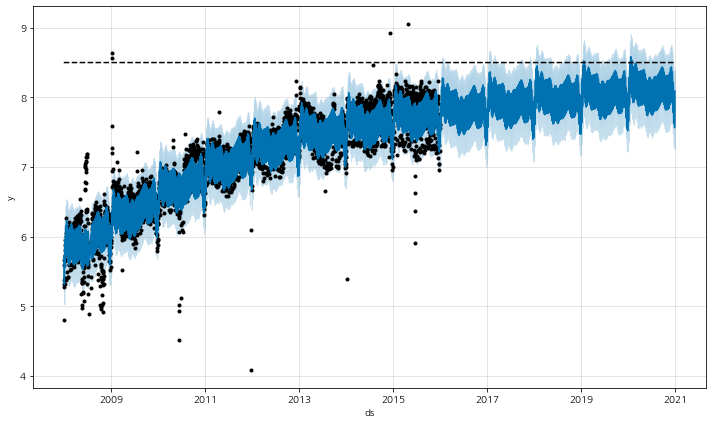

In [37]:
future = m.make_future_dataframe(periods=1826)
future['cap'] = 8.5
fcst = m.predict(future)
m.plot(fcst);

이런 종류의 데이터를 예측하는 것도 가능하다는 것을 알 수 있습니다. 거기에 역시 components를 조사하도록 하겠습니다.

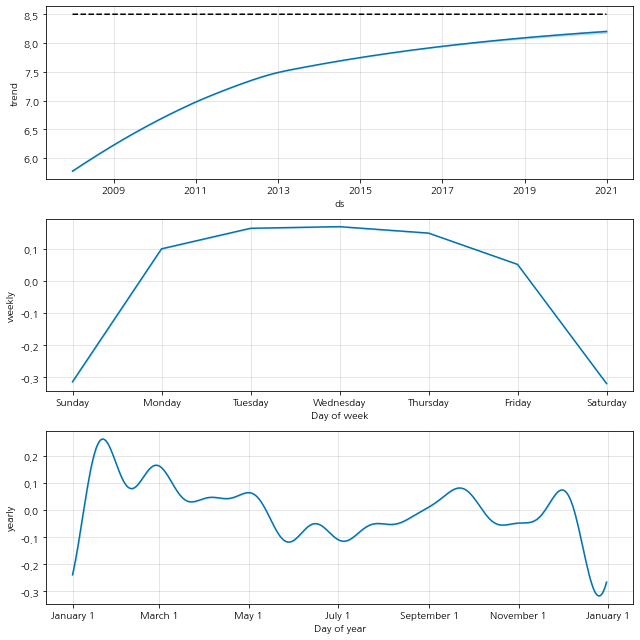

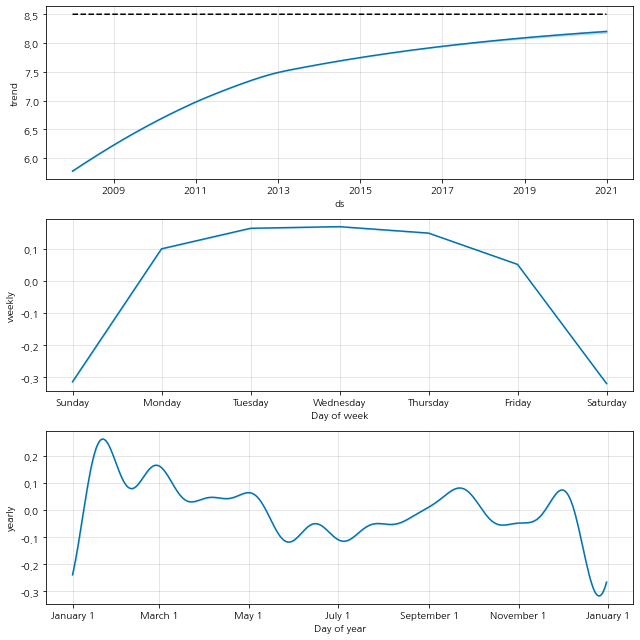

In [38]:
forecast = m.predict(future)
m.plot_components(forecast);m.plot_components(forecast);

전체적인 경항(trend)이 나타납니다.<br>
그리고 주간 분석도 나타나고 있습니다<br>
그리고 연간 분석의 결과도 나타납니다.<br>
이번 장은 모듈을 소개하고 간단히 모듈의 사용만으로 에측(forecast)이라는 어려운 과정을 손쉽게 확인했습니다. 이 책에서 가장 작은 분량이지만 쓰임새는 작지 않을 겁니다.

출처 : "파이썬으로 데이터 주무르기"